# Make a software package for generating train/test data

# Add resampling, and fix all the timescales

+ Utilities for combining models / directional forcing
+ Sample at same rate
+ Easily integrate ensembles of trajectories

In [23]:
%%bash 
pip install -I .

Processing /Users/williamgilpin/program_repos/dysts
  Created wheel for dysts: filename=dysts-0.0.0-py3-none-any.whl size=49262 sha256=b91f257c1a1424cad3204d27821570abe86e82aa034af555f9527fdb044ea687
  Stored in directory: /private/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/pip-ephem-wheel-cache-lk2gsle4/wheels/11/5b/88/16c919af072e1e7c772aefa7da5a0b20f7490b27e409b1dcf5
Successfully built dysts


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [24]:
import sys

import matplotlib.pyplot as plt

from dysts.flows import *
from dysts.base import *
from dysts.utils import *

from private.lyap import lyap_r, lyap_e, corr_dim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
model = Lorenz() # λ1 = 2.0686, λ2 = −0.0115, λ3 = −32.3537, dim ~ 2
model.sigma = 16
model.rho = 45.92
model.beta = 4.0
# model.dt =1e-3

# model = Rossler() # λ1 = 0.13, λ2 = 0, λ3 = −14.1, dim ~ 2
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# # model.dt = 1e-2

tpts, sol = model.make_trajectory(10000, resample=True, pts_per_period=300, return_times=True)
dt = np.median(np.diff(tpts))
print(lyap_r(sol.T, tau=dt), corr_dim(sol.T))




/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 2500
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


1.905062030809844 2.0052564617847226


In [206]:
model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
model.a = 0.15
model.b = 0.2
model.c = 10
model.dt =1e-2

model.ic = np.array([  4.66009155, -12.12441564,   0.29234687])


tpts, sol = model.make_trajectory(10000, resample=True, pts_per_period=150, return_times=True)

In [133]:
model = Lorenz()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), 100, replace=False)
sample_pts = initial_sol[:, sample_inds].T

model.ic = sample_pts

tpts, sol = model.make_trajectory(1000, resample=True, pts_per_period=30, return_times=True)
dt = np.median(np.diff(tpts))

KeyboardInterrupt: 

In [126]:
all_estimates_lyap = [lyap_r(item, tau=dt) for item in sol]
all_estimates_corr = [corr_dim(item) for item in sol]

print(np.median(all_estimates_lyap))
print(np.median(all_estimates_corr))

/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/lyap.py:332: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 250
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/williamgilpin/program_repos/thom/private/ly

1.3612105696228687
1.9364653042686115


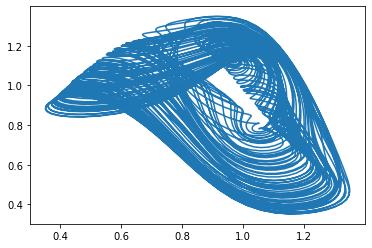

In [5]:
eq = MackeyGlass()

sol = eq.make_trajectory(5000, resample=True)
# eq.ic = np.vstack([eq.ic, eq.ic])

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[0], sol[1])
# plt.plot(sol[0][:50000], sol[1][:50000])

## Make Lorenz Ensemble for classification

# Finding Lyapunov exponents

In [310]:
model.b

0.2

In [305]:
np.median(np.array(lyap_list), axis=0)

array([-4.59650544,  0.06752232,  0.15855425])

In [300]:
model =  Rossler()
model.a = 0.15
model.c = 10
print([model.a, model.b, model.c])

# a = 0.15, b = 0.20, c = 10

[0.15, 0.2, 10]


In [301]:
model =  Rossler()
model.a = 0.15
model.c = 10

sol = model.make_trajectory(8000, method="Radau", resample=True, pts_per_period=300)
plt.plot(sol[1], sol[2])

In [87]:
np.sort(lexp)

array([3.38248042e-08, 3.52673735e-08, 1.13320694e-07])

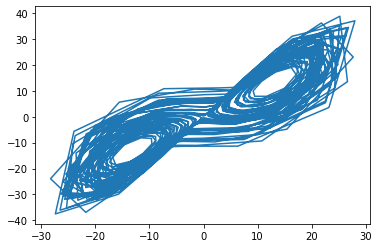

In [104]:
plt.plot(initial_sol[0], initial_sol[1])

In [2]:
model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
model.sigma = 16
model.rho = 45.92
model.beta = 4.0

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3

points_to_sample = 20
m = 5 # number of timesteps to use to find the jacobian

lyap_list = list()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), points_to_sample, replace=False)
sample_pts = initial_sol[:, sample_inds].T
(d, _) = initial_sol.shape
print("Finished selecting initial points on attractor.")

all_estimates_lyap = list()
for i, sample_pt in enumerate(sample_pts):
    if i % 5 == 0: print(i)
    model.ic = sample_pt
    model.ic = make_epsilon_ball(model.ic, 400).T
    tpts, traj_ball = model.make_trajectory(m, resample=True, pts_per_period=30, return_times=True)
    dt = np.median(np.diff(tpts))
    
    traj_ball -= np.mean(traj_ball, axis=0, keepdims=True)

    cov = np.einsum("kim,kin->imn", traj_ball, traj_ball) / (traj_ball.shape[0] - 1)
    eigs, vecs = np.linalg.eigh(cov)
    rads = np.sqrt(eigs)
    rads /= rads[0, :][None, :]

    assert np.all(np.diff(np.argsort(eigs, axis=1), axis=1) == 1), "Eigenvalues are not sorted; please report this bug."

    xinds = np.tile(np.arange(eigs.shape[0]), (eigs.shape[1], 1))

    # rads = np.sqrt(np.sum((traj_ball[[1, 2, 9]] - traj_ball[[3, 4, 8]])**2, axis=-1).T)
    # rads /= rads[0, :][None, :]

    
    all_lyap = find_slope(xinds, np.log(rads.T)) / dt

    print(all_lyap)
    
    lyap_list.append(all_lyap)
    
print("\nFinal estimate: ", np.median(np.array(lyap_list), axis=0)[::-1])    




Finished selecting initial points on attractor.
0


NameError: name 'make_epsilon_ball' is not defined

In [362]:
x0 = make_epsilon_ball(curr, pts_to_estimate_jacobian, eps=1e-8).T
y0 = x0 + np.vstack(model.rhs(x0, 0)).T * model.dt
x = x0 - np.mean(x0, axis=0)
y = y0 - np.mean(y0, axis=0)
curr = model.make_trajectory(2, resample=False)[:, -1]


xinv = np.linalg.pinv(x.T)
tm = np.dot(y.T, xinv)

In [529]:
NUMBA_DISABLE_JIT

In [2]:
from dysts.analysis import sample_initial_conditions, find_lyapunov_exponents

model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
# model.sigma = 16
# model.rho = 45.92
# model.beta = 4.0
# model.dt = 1e-4


# model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
# model.dt = 1e-2
# model.dt = 1e-4

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3




points_to_sample = 10 # number of points to sample in ensemble
sample_pts = sample_initial_conditions(model, points_to_sample)
print("Finished selecting initial points on attractor.")

pts_per_trajectory = 5000 # number of timesteps to use to find the jacobian
model.dt /= 10

lyap_list = list()

all_estimates_lyap = list()
for j, sample_pt in enumerate(sample_pts):
    if j % 5 == 0: print(j)
    model.ic = sample_pt
    all_estimates_lyap.append(find_lyapunov_exponents(model, pts_per_trajectory, pts_per_period=500))
    print("Current Average: ", np.mean(np.array(all_estimates_lyap), axis=0))

print("Final Average: ", np.mean(np.array(all_estimates_lyap), axis=0))

Finished selecting initial points on attractor.
0
Current Average:  [  1.04928904   0.04947287 -14.89954179]
Current Average:  [  0.95345687   0.03081662 -14.76699195]
Current Average:  [ 9.46111105e-01 -1.46633199e-02 -1.47087465e+01]
Current Average:  [ 9.54785749e-01 -9.50014502e-04 -1.47335638e+01]
Current Average:  [  0.96901841   0.02214661 -14.773275  ]
5
Current Average:  [  0.95383052   0.02669042 -14.76210779]
Current Average:  [  0.95858346   0.02261121 -14.76347615]
Current Average:  [  0.95838948   0.02626707 -14.76714349]
Current Average:  [ 9.79124118e-01  1.02856827e-02 -1.47728935e+01]
Current Average:  [ 9.79315852e-01  1.28190110e-02 -1.47757511e+01]
Final Average:  [ 9.79315852e-01  1.28190110e-02 -1.47757511e+01]


In [311]:

model =  Rossler()
number_of_positions = 10




initial_sol = model.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), number_of_positions, replace=False)
sample_pts = initial_sol[:, sample_inds].T

all_initial_points = np.hstack([make_epsilon_ball(pt, 100) for pt in sample_pts])


model.ic = all_initial_points.T
tpts, traj_ball = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)

traj_ball_expanded = np.stack(np.array_split(traj_ball, number_of_positions))

In [83]:
traj_ball_expanded = np.stack(np.array_split(traj_ball, number_of_positions))

In [228]:
sample_inds = np.random.choice(np.arange(initial_sol.shape[1]), 200, replace=False)
sample_pts = initial_sol[:, sample_inds].T

In [56]:
sample_pts = initial_sol[:, sample_inds, :]

In [24]:
def make_diverging_trajectory(model, m=100, n=1000, number_of_positions=30, points_per_position=100):
    """
    
    Args:
        points_per_position (int): the number of points to use to estimate the exponents at each position
        
    """
    
    ## Select a set of initial conditions
    model.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
    initial_sol = eq.make_trajectory(1000, method="Radau", resample=True, pts_per_period=30)
    sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), number_of_positions, replace=False)
    sample_pts = initial_sol[:, sample_inds].T
    
    all_ic = list()
    for pt in sample_pts:
        all_ic.append(make_epsilon_ball(pt, points_per_position))
    all_ic = np.array(all_ic)
    

    

def find_max_lyapunov(traj1, traj2, dt=1.0, return_error=False):
    """
    Given two diverging trajectories (or batches of diverging trajectories), 
    calculate the maximum lyapunov exponent by fitting an exponential
    
    Args:
        traj1 (ndarray): A batch of trajectories (B, T, D) or a single trajectory (T, D)
        traj2 (ndarray): Same as above
        dt (float): the timestep
        
    Returns:
        lyap (float): the lyapunov exponent
    
    """
    traj_differences = np.sum((traj1 - traj2)**2, axis=-1)
    if len(traj_differences.shape) == 1:
        traj_differences = traj_differences[None, ...]
    print(traj_differences.shape)
    lyapunov_estimates = list()
    for item in traj_differences :
        p = np.polyfit(np.arange(len(item)), np.log(item), 1)
        lyapunov_estimates.append(p[0] / dt)
        
    if not return_error:
        return np.mean(lyapunov_estimates)
    else:
        return np.mean(lyapunov_estimates), np.std(lyapunov_estimates)
    
# find_max_lyapunov(reference_sol, perturbed_sol)

0.11724657837664709
0.091538689611144
0.0747938103348513
0.10210668052562039
0.07792294157046326
0.0756377237311469
0.09588256276009974
0.09245191638402186
0.11921422066892312
0.06007677109096802
0.0765486563577143
0.08807025340391805
0.11397719729595215
0.09718435857359387
0.08793920685477627
0.07512608670968228
0.10851936689085082
0.10103748883790843
0.08035874127109167
0.1082608742453971
0.11134593024239639
0.07667330343320244
0.09706534746412329
0.09791770106346652
0.07635269375453792
0.06839459377435295
0.06198221233437269
0.08738636810402822
0.056973163187860575
0.0924723037986079
0.08663658504524836
0.08248745636092729
0.09816441542032049
0.11130613473893385
0.12252211899992854
0.11859019363156889
0.11055232660157097
0.09622489186901509
0.06595744195946696
0.1033357217523389
0.10932854491389095
0.07901226629889209
0.10443147664773103
0.09352210711768173
0.09860683136695748
0.05918570189080563
0.10310295289817363
0.1136739828695531
0.10805441062123615
0.04417025224641917
median 0

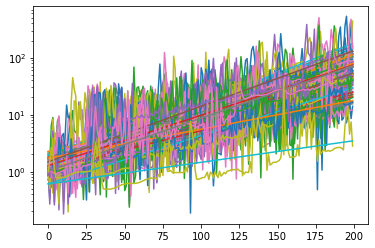

In [22]:
## Test the simple stretching lyapunov code

import scipy
from scipy.optimize import curve_fit

model = Lorenz() # λ1 = 2.0686, λ2 = −0.0115, λ3 = −32.3537
model.sigma = 16
model.rho = 45.92
model.beta = 4.0


model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
model.a = 0.15
model.b = 0.2
model.c = 10


# model = Rossler()
# model.a = 0.15
# model.c = 10
m = 50
# sol = eq.make_trajectory(10000, method="Radau", resample=True, pts_per_period=30)

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), m, replace=False)
sample_pts = initial_sol[:, sample_inds].T

model.ic = sample_pts
tpts, reference_sol = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)
model.ic = sample_pts * (1 + 1e-5)
tpts, perturbed_sol = model.make_trajectory(200, method="Radau", resample=True, pts_per_period=30, return_times=True)

errs_sol = np.sqrt(np.sum((reference_sol - perturbed_sol)**2, axis=-1))
errs_sol /= errs_sol[:, 0][:, None]



# def exponential(x, a, k):
#     return a * np.exp(k * x)

all_m = list()
for item in errs_sol:
    plt.semilogy(item)
#     popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, np.arange(len(item)), item, p0=[1.0, 0.1])
#     plt.semilogy(np.arange(len(item)), exponential(np.arange(len(item)), *popt_exponential))
    
    ## Need to fetch time vals because of resampling
    
    p = np.polyfit(np.arange(len(item)), np.log(item), 1)
    poly = np.poly1d(p)
    plt.semilogy(np.arange(len(item)), np.exp(poly(np.arange(len(item)))))
    
    dtval = np.median(np.diff(tpts))
    lyap = p[0] / dtval
    print(lyap)
    
    all_m.append(lyap)
    
print("median", np.median(all_m))

In [27]:

# insert a control function that takes the current values of all vars and adds forcing

# various functions for sampling from each system, and removing transients

# function that goes to numba

# function that couples attractors together (can use slaving to force chaos)

In [ ]:
#https://stackoverflow.com/questions/1796180/how-can-i-get-a-list-of-all-classes-within-current-module-in-python

In [27]:
## test jacobian calc

model = Lorenz()
sol = model.make_trajectory(200)

# analytic jacobian for lorenz
def jac(X, t, model):
    x, y, z = X
    return np.array([[-model.sigma, model.sigma, 0], [model.rho - z, -1, -x], [y, x, -model.beta]])

ind = 100
y0 = sol[ind]

rhsy = lambda y : model.rhs(y, 0)
print(jac_fd(rhsy, y0), "\n")

print(jac(y0, 0, model))

[[-10.00000083  10.00000083   0.        ]
 [  5.62466766  -1.00000008  10.73500471]
 [-15.9712755  -10.73500471  -2.66699942]] 

[[-10.          10.           0.        ]
 [  5.62466765  -1.          10.73500436]
 [-15.97127533 -10.73500436  -2.667     ]]


In [ ]:
model = Lorenz() # λ1 = 2.16, λ2 = 0, λ3 = −32.4
model.sigma = 16
model.rho = 45.92
model.beta = 4.0
model.dt = 1e-4

# model = Rossler() # λ1z = 0.13, λ2 = 0, λ3 = −14.1
# model.a = 0.15
# model.b = 0.2
# model.c = 10
# model.dt = 1e-3

points_to_sample = 20 # number of points to sample in ensemble
pts_to_estimate_jacobian = 200
pts_per_trajectory = 1000 # number of timesteps to use to find the jacobian
pred_step = 1

lyap_list = list()

initial_sol = model.make_trajectory(1000, resample=True, pts_per_period=30)
sample_inds = np.random.choice(np.arange(initial_sol.shape[-1]), points_to_sample, replace=False)
sample_pts = initial_sol[:, sample_inds].T
d = initial_sol.shape[0]
print("Finished selecting initial points on attractor.")

# analytic jacobian for lorenz
def jac(X, t, model):
    x, y, z = X
    return np.array([[-model.sigma, model.sigma, 0], [model.rho - z, -1, -x], [y, x, -model.beta]])

jac(initial_sol[:, -1], 0, model)

all_estimates_lyap = list()
for j, sample_pt in enumerate(sample_pts):
    if j % 5 == 0: print(j)
        

#     model.ic = sample_pt
#     model.ic = make_epsilon_ball(model.ic, pts_to_estimate_jacobian, eps=1e-8).T
#     tpts, traj_ball = model.make_trajectory(pts_per_trajectory, pts_per_period=80, 
#                                             resample=True, return_times=True)
#     dt = np.median(np.diff(tpts))
#     traj_ball -= np.mean(traj_ball, axis=0) # subtract center of ball
    
    curr = sample_pt
    
    old_Q = np.identity(d)
    lexp = np.zeros(d)
    lexp_counts = np.zeros(lexp.shape)
    for i in range(pred_step, pts_per_trajectory): # number of timepoints

        x0 = make_epsilon_ball(curr, pts_to_estimate_jacobian, eps=1e-5).T
        y0 = x0 + np.vstack(model.rhs(x0, 0)).T * model.dt
        x = x0 - np.mean(x0, axis=0)
        y = y0 - np.mean(y0, axis=0)
        curr = model.make_trajectory(2, resample=False)[:, -1]
            
        
            
#         x = traj_ball[:, i - pred_step]
#         y = traj_ball[:, i]
        
        
        xinv = np.linalg.pinv(x.T)
        tm = np.dot(y.T, xinv)
        
        
        tm = jac(curr, 0, model)
        
        
        mat_T = tm
        # QR-decomposition of T * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(mat_T, old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)

        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape)
        lexp_i[idx] = np.log(diag_R[idx])
        lexp_i[np.where(diag_R == 0)] = np.inf
#         if debug_plot or debug_data:
#             debug_values.append(lexp_i / tau / m)
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

    
     # normalize exponents over number of individual mat_Rs
    idx = np.where(lexp_counts > 0)
    lexp[idx] /= lexp_counts[idx]
    lexp[np.where(lexp_counts == 0)] = np.inf
    # normalize with respect to timestep (also and number of steps?)
    lexp /= (pred_step * dt)
    all_estimates_lyap.append(lexp)
    
#     print(lexp)
    print("\nCurrent Median Estimate: ", np.median(np.array(all_estimates_lyap), axis=0))
    
  
print("\nFinal Estimate: ", np.median(np.array(all_estimates_lyap), axis=0))

#     traj_ball -= np.mean(traj_ball, axis=0, keepdims=True)

#     cov = np.einsum("kim,kin->imn", traj_ball, traj_ball) / (traj_ball.shape[0] - 1)
#     eigs, vecs = np.linalg.eigh(cov)
#     rads = np.sqrt(eigs)
#     rads /= rads[0, :][None, :]

#     assert np.all(np.diff(np.argsort(eigs, axis=1), axis=1) == 1), "Eigenvalues are not sorted; please report this bug."

#     xinds = np.tile(np.arange(eigs.shape[0]), (eigs.shape[1], 1))

#     # rads = np.sqrt(np.sum((traj_ball[[1, 2, 9]] - traj_ball[[3, 4, 8]])**2, axis=-1).T)
#     # rads /= rads[0, :][None, :]

    
#     all_lyap = find_slope(xinds, np.log(rads.T)) / dt

#     print(all_lyap)
    
#     lyap_list.append(all_lyap)
    
# print("\nFinal estimate: ", np.median(np.array(lyap_list), axis=0)[::-1])    

# p = np.polyfit(np.arange(len(item)), np.log(item), 1)
# poly = np.poly1d(p)

# cov = np.cov(x_std.T)
# ev , eig = np.linalg.eig(cov)
# a = eig.dot(x_std.T)


## Debug Lyapunov code

In [ ]:
from dysts.utils import jac_fd
import numpy as np




def rhsyy(X):
    x, y, z = X
    return np.array([x, y, z])

def y2h(X):
    x, y, z = X
    return np.array([x, y * z**2, z * y])

y0 = np.array([1.1, 3, 4.6])
dt = 1e-3

    


In [ ]:



pert = np.array([0.0, 0.0, 0.0])
pert[2] = 1e-3


# j2 = jac_fd(ff2, y0) # dhi / dyj
# print(j2) # dh / dy


# rhsyy = lambda y : (y + dt * rhsyy(*y) - y) / dt
# rhs_est = ff(*ynxt) - ff(*y0) / dt
rhsh1 = lambda y : (y2h(y + dt * rhsyy(y)) - y2h(y)) / dt # dh/dt
rhsh2 = lambda y: jac_fd(y2h, y) @ rhsyy(y) # dh/dy * dy/dt = dh/dt
print("dh/dt: \n", rhsh1(y0))
print("dh/dt: \n", jac_fd(y2h, y0) @ rhsyy(y0), "\n")
print("dh/dt: \n", rhsh2(y0), "\n")


print("dhdot/dh (1): \n",  jac_fd(rhsh1, y0), "\n\n") # d(dh/dt)/dy
print("dhdot/dh (2): \n",  jac_fd(rhsh2, y0, eps=1e-3)) # d(dh/dt)/dy
print("dhdot/dh (3): \n",  jac_fd(rhsh2, y0, eps=1e-3)) # d(dh/dt)/dy


print("dhdot/dh (1): \n",  jac_fd(rhsh1, y0) @ np.linalg.inv(jac_fd(y2h, y0)), "\n\n") # d(dh/dt)/dy * dy/dh
print("dhdot/dh (2): \n",  jac_fd(rhsh2, y0, eps=1e-3) @ np.linalg.inv(jac_fd(y2h, y0))) # d(dh/dt)/dy * dy/dh
print("dhdot/dh (3): \n",  jac_fd(rhsh2, y0, eps=1e-6) @ np.linalg.inv(jac_fd(y2h, y0))) # d(dh/dt)/dy * dy/dh

# print("dhdot/dh (4): \n", jac_fd(y2h, y0, m=2, eps=1e-2) @ rhsyy(y0) + jac_fd(y2h, y0) @ jac_fd(rhsyy, y0))

# print("dhdot/dh (1): \n",  jac_fd(rhsh1, y0) @ np.linalg.inv(jac_fd(y2h, y0)), "\n\n") # d(dh/dt)/dy * dy/dh
# print("dhdot/dh (2): \n",  jac_fd(rhsh2, y0) @ np.linalg.inv(jac_fd(y2h, y0))) # d(dy/dt)/dy * dy/db
# print("dhdot/dh (2): \n",  jac_fd(rhsh2, y0) @ np.linalg.inv(jac_fd(y2h, y0)), "\n") # 





# print("dhdot/dh: \n",  jac_fd(rhsh1, y0) @ np.linalg.inv(j2))# # dhdot/dy * dy/dh
# print("dhdot/dh: \n",  jac_fd(rhsh2, y0) @ np.linalg.inv(j2))# # dhdot/dy * dy/dh
# print("dhdot/dh: \n", jac_fd(rhsf, y0) @ np.linalg.inv(j2),  "\n")

# ff2 = lambda x : ff(*x)
# j2 = jac_fd(ff2, y0)
# print(jac_fd(rhs1, y0) @ j2) # (dh / dy) * (dydot / dy) 